<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = u'D:\capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    sessions_list = []
    with open(site_freq_path, 'rb') as f:
        freq_dict = pickle.load(f)
    users_files = sorted(glob(os.path.join(path_to_csv_files, 'user[0-9][0-9][0-9][0-9].csv')))
    for user in tqdm_notebook(users_files):
        user_data = pd.read_csv(user)
        site_list = user_data.site.values
        timestamp_list = [pd.to_datetime(timestamp) for timestamp 
                          in user_data.timestamp.values]
        session = {}  # Current session
        for i in range(0, len(site_list), window_size):
            site_window = site_list[i: i + session_length]
            for j, site in enumerate(site_window):
                session['site{}'.format(j + 1)] = freq_dict[site][0]
            unique_sites = np.unique(site_window).shape[0]
            time_window = timestamp_list[i: i + session_length]
            for k, timestamp in enumerate(time_window[:-1]):
                session['time_diff{}'.format(k + 1)] = (time_window[k + 1] - timestamp).total_seconds()
            session['target'] = int(user.strip('.csv')[-4:])
            session['session_timespan'] = (time_window[-1] - time_window[0]).total_seconds()
            session['#unique_sites'] = unique_sites
            session['start_hour'] = time_window[0].hour
            session['day_of_week'] = time_window[0].weekday()
            sessions_list.append(session)
            session = {}
    dframe = pd.DataFrame(sessions_list, columns=feature_names).fillna(0).astype(int)
    return dframe

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,4,2,2,11,2,1,8,5,9,7,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,4,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,5,10,3,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [7]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)


Wall time: 8.93 s


In [8]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,586,134,3,134,134,3,134,204,134,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,416,193,683,256,134,31,393,3514,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,416,337,918,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,483,3735,483,55,55,55,55,982,201,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,348,55,5,4459,259,212,4216,2418,684,2418,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [9]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)


Wall time: 1min 28s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [10]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [12]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [13]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

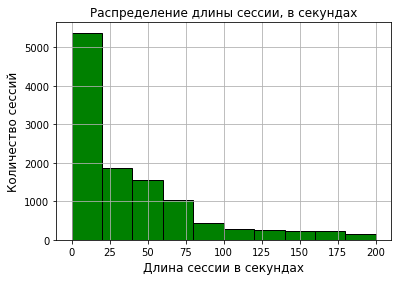

In [17]:
train_data_10users['session_timespan'].hist(range=(0, 200), color='green', edgecolor='black')
plt.xlabel(u'Длина сессии в секундах', fontsize='large')
plt.ylabel(u'Количество сессий', fontsize='large')
plt.title(u'Распределение длины сессии, в секундах', fontsize='large')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

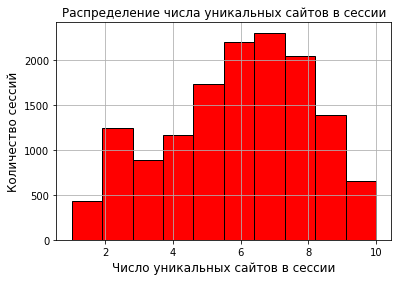

In [19]:
train_data_10users['#unique_sites'].hist(range=(1, 10), bins=10, 
                                         color='red', edgecolor='black')
plt.xlabel(u'Число уникальных сайтов в сессии', fontsize='large')
plt.ylabel(u'Количество сессий', fontsize='large')
plt.title(u'Распределение числа уникальных сайтов в сессии', fontsize='large')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

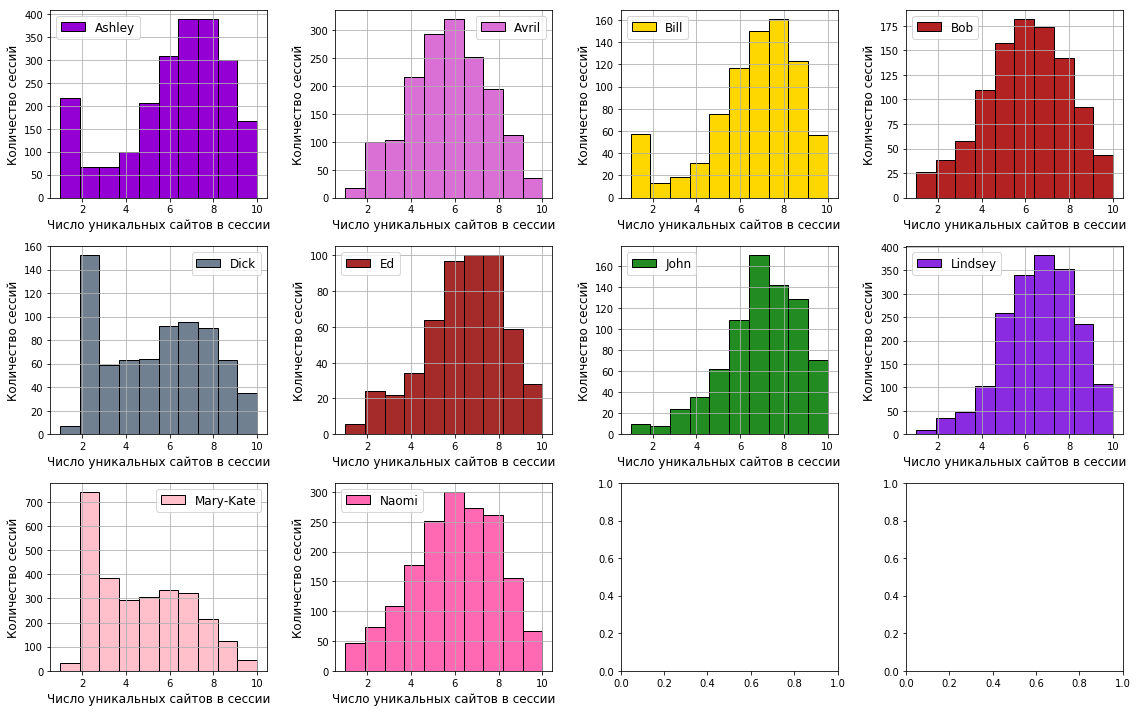

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    sub_df['#unique_sites'].hist(range=(1, 10), bins=10, color=color_dic[user], 
                                 ax=axes[idx//4, idx%4], edgecolor='black')
    axes[idx//4, idx%4].set_xlabel(u'Число уникальных сайтов в сессии', fontsize='large')
    axes[idx//4, idx%4].set_ylabel(u'Количество сессий', fontsize='large')
    axes[idx//4, idx%4].legend([user], fontsize='large')
plt.tight_layout()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

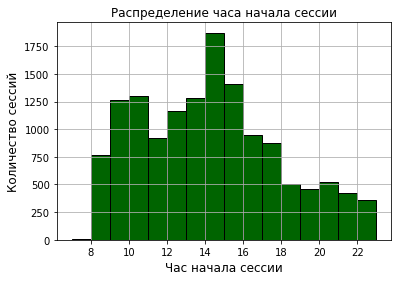

In [21]:
bins = range(train_data_10users.start_hour.min(), 
             train_data_10users.start_hour.max() + 1)
train_data_10users['start_hour'].hist(bins=bins, color='darkgreen', 
                                      edgecolor='black')
plt.xlabel(u'Час начала сессии', fontsize='large')
plt.ylabel(u'Количество сессий', fontsize='large')
plt.title(u'Распределение часа начала сессии', fontsize='large')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

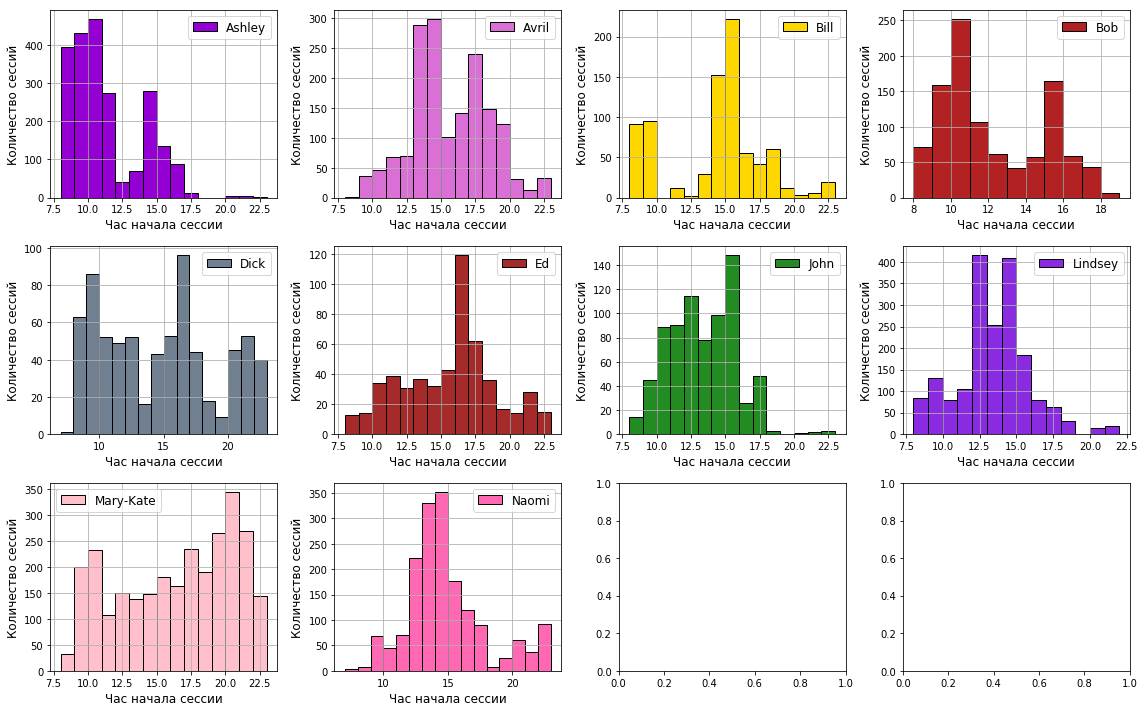

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    bins = range(sub_df.start_hour.min(), 
                 sub_df.start_hour.max() + 1)
    sub_df['start_hour'].hist(color=color_dic[user], ax=axes[idx//4, idx%4], 
                              bins=bins, edgecolor='black')
    axes[idx//4, idx%4].set_xlabel(u'Час начала сессии', fontsize='large')
    axes[idx//4, idx%4].set_ylabel(u'Количество сессий', fontsize='large')
    axes[idx//4, idx%4].legend([user], fontsize='large')
plt.tight_layout()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

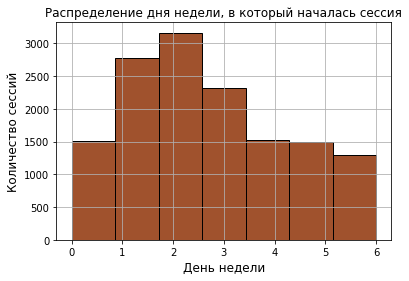

In [24]:
train_data_10users['day_of_week'].hist(color='sienna', bins=7, 
                                       range=(0, 6), edgecolor='black')
plt.xlabel(u'День недели', fontsize='large')
plt.ylabel(u'Количество сессий', fontsize='large')
plt.title(u'Распределение дня недели, в который началась сессия', fontsize='large')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

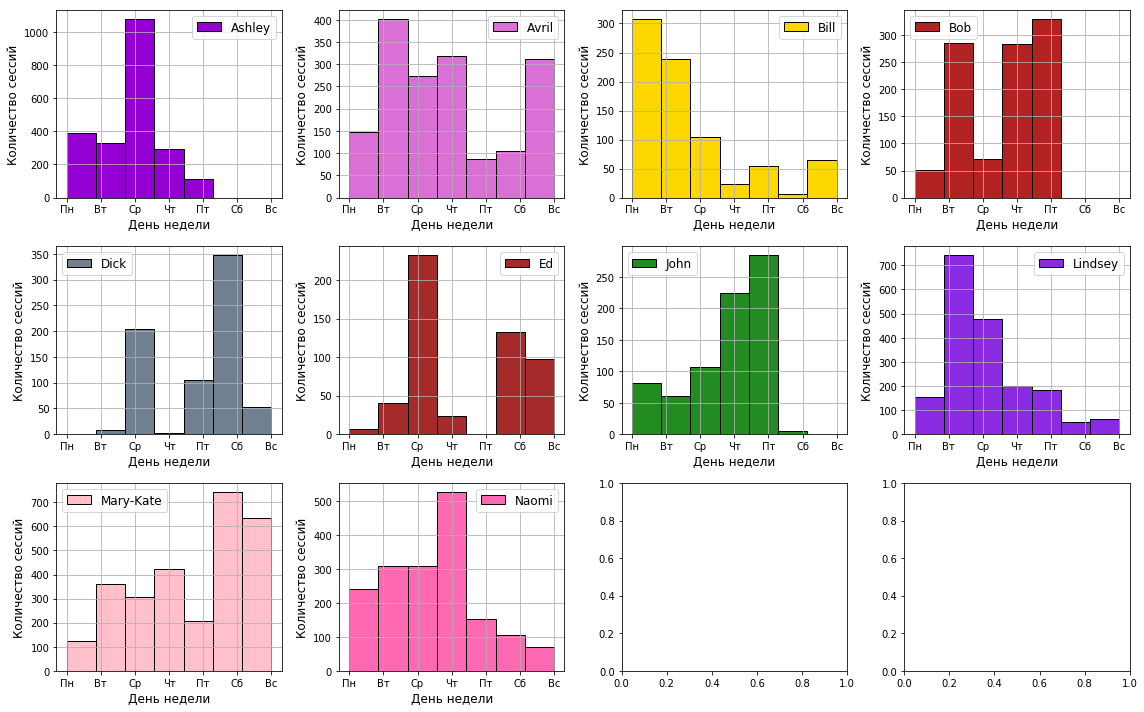

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    sub_df['day_of_week'].hist(color=color_dic[user], ax=axes[idx//4, idx%4], 
                               bins=7, range=(0, 6), edgecolor='black')
    axes[idx//4, idx%4].set_xlabel(u'День недели', fontsize='large')
    axes[idx//4, idx%4].set_ylabel(u'Количество сессий', fontsize='large')
    axes[idx//4, idx%4].set_xticks(np.arange(7))
    axes[idx//4, idx%4].set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    axes[idx//4, idx%4].legend([user], fontsize='large')
plt.tight_layout()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

По построенным графикам можно сделать некоторые выводы:

#### Ashley

Посещает разные сайты; пользуется интернетом утром и днем; имеется выраженный пик активности в утренние часы; выходит в интернет в рабочие дни.

#### Avril

Посещает по большей части разные сайты; пользуется интернетов днем и ближе к вечеру; имеются два выраженных пика активности (13:00-14:00, 17:00); выходит в интернет на протяжении всей недели, но наиболее активно во вторник, среду, четверг и воскресенье.

#### Bill

Посещает разные сайты; пользуется интернетом утром и днем; имеется выраженный пик активности в дневные часы; выходит в интернет на протяжении всей недели, но наиболее активно в понедельник и вторник.

#### Bob

Посещает по большей части разные сайты; пользуется интернетом утром и днем; имеются два выраженных пика активности (10:00, 15:00); выходит в интернет в рабочие дни, наиболее активно во вторник, четверг и пятницу.

#### Dick

У данного пользователя имеется большое количество сессий с двумя уникальными сайтами, однако и имеется умеренное количество сессий с большим числом уникальных сайтов; пользуется интернетом на протяжении всего дня; имеются два выраженных пика активности (09:00, 16:00); выходит в интернет во все дни, кроме понедельника, наиболее активно в среду и субботу.

#### Ed

Посещает разные сайты; пользуется интернетом на протяжении всего дня, наиболее активно в дневное время; имеется выраженный пик активности (16:00); выходит в интернет на протяжении всей недели, кроме пятницы, наиболее активно в среду, субботу и воскресенье.

#### John

Посещает разные сайты; пользуется интернетом по большей части в дневное время; имеется выраженный пик активности (15:00); выходит в интернет в рабочие дни, наиболее активно в четверг и пятницу.

#### Lindsey

Посещает по большей части разные сайты; пользуется интернетом утром и днем, наиболее активно в дневное время; имеются два выраженных пика активности (12:00, 14:00); выходит в интернет на протяжении всей недели, наиболее активно во вторник и среду.

#### Mary-Kate

У данного пользователся имеется большое количество сессий с двумя уникальными сайтами, остальные сессии имеют в основном от трех до семи уникальных сайтов; пользуется интернетом на протяжении всего дня, активность пользователя линейно возрастает с утра до 20:00; имеется выраженный пик активности (20:00); выходит в интернет на протяжении всей недели, наиболее активно в субботу и воскресенье.

#### Naomi

Посещает по большей части разные сайты; пользуется интернетом на протяжении всего дня, наиболее активно днем; имеется выраженный пик активности (13:00-14:00); выходит в интернет на протяжении всей недели, наиболее активно в рабочие дни; имеется пик активности в четверг.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [26]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10users = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [27]:
top10_freqs = [val[1] for val in list(site_freq_10users.values())[:10]]
top10_sites = list(site_freq_10users.keys())[:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

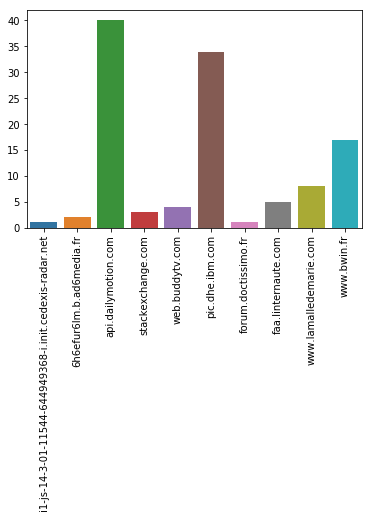

In [28]:
sns.barplot(top10_sites, top10_freqs)
plt.xticks(rotation=90)
plt.show()

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [29]:
np.median(train_data_10users['session_timespan'])

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [30]:
np.median(train_data_10users['day_of_week'])

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [31]:
np.median(train_data_150users['start_hour'])

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [32]:
np.median(train_data_150users['#unique_sites'])

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [33]:
def feature_engineering(path_to_csv_files, site_freq_path, 
                        features, session_length=10, window_size=10):
    sessions_list = []
    with open(site_freq_path, 'rb') as f:
        freq_dict = pickle.load(f)
    top30_sites = list(site_freq_10users.keys())[:30]
    users_files = sorted(glob(os.path.join(path_to_csv_files, 'user[0-9][0-9][0-9][0-9].csv')))
    for user in tqdm_notebook(users_files):
        user_data = pd.read_csv(user)
        site_list = user_data.site.values
        timestamp_list = [pd.to_datetime(timestamp) for timestamp 
                          in user_data.timestamp.values]
        session = {}  # Current session
        for i in range(0, len(site_list), window_size):
            session['popular_sites'] = 0
            session['popular_sites_time'] = 0
            site_window = site_list[i: i + session_length]
            time_window = timestamp_list[i: i + session_length]
            for site in site_window:
                if site in top30_sites:
                    session['popular_sites'] += 1
                else:
                    continue
            for j, timestamp in enumerate(time_window[:-1]):
                if site_window[j] in top30_sites:
                    session['popular_sites_time'] += (time_window[j + 1] - timestamp).total_seconds()
                else:
                    continue
            session['target'] = int(user.strip('.csv')[-4:])
            sessions_list.append(session)
            session = {}
    dframe = pd.DataFrame(sessions_list, columns=features).fillna(0).astype(int)
    return dframe

In [34]:
new2_features_10users = feature_engineering(
        path_to_csv_files=os.path.join(PATH_TO_DATA, '10users'), 
        site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
        features=['popular_sites', 'popular_sites_time', 'target'], 
        session_length=10, window_size=10)

In [35]:
new2_features_150users = feature_engineering(
        path_to_csv_files=os.path.join(PATH_TO_DATA, '150users'), 
        site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
        features=['popular_sites', 'popular_sites_time', 'target'], 
        session_length=10, window_size=10)

In [36]:
with open(os.path.join(PATH_TO_DATA, 
                       'new2_features_10users.pkl'), 'wb') as new2_features_10users_pkl:
    pickle.dump(new2_features_10users, new2_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new2_features_150users.pkl'), 'wb') as new2_features_150users_pkl:
    pickle.dump(new2_features_150users, new2_features_150users_pkl)

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

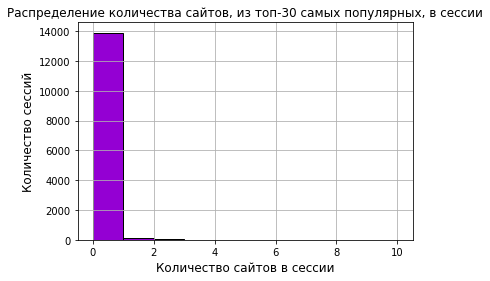

In [39]:
new2_features_10users['popular_sites'].hist(range=(0, 10), bins=10, 
                                           color='darkviolet', edgecolor='black')
plt.xlabel(u'Количество сайтов в сессии', fontsize='large')
plt.ylabel(u'Количество сессий', fontsize='large')
plt.title(u'Распределение количества сайтов, из топ-30 самых популярных, в сессии')
plt.show()

Гистограммы распределения количества сайтов, из топ-30 самых популярных, в сессии:


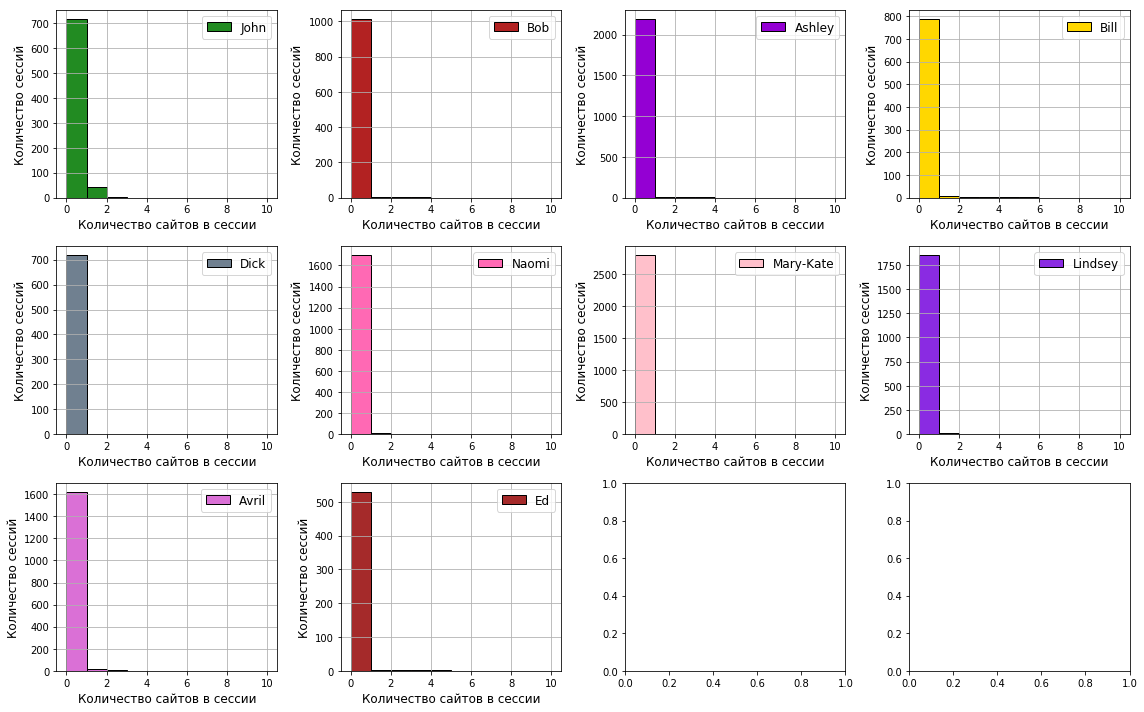

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
print(u'Гистограммы распределения количества сайтов, из топ-30 самых популярных, в сессии:')

for idx, (user, sub_df) in  enumerate(new2_features_10users.groupby('target')): 
    sub_df['popular_sites'].hist(color=color_dic[id_name_dict[user]], ax=axes[idx//4, idx%4], 
                               bins=10, range=(0, 10), edgecolor='black')
    axes[idx//4, idx%4].set_xlabel(u'Количество сайтов в сессии', fontsize='large')
    axes[idx//4, idx%4].set_ylabel(u'Количество сессий', fontsize='large')
    axes[idx//4, idx%4].legend([id_name_dict[user]], fontsize='large')
plt.tight_layout()

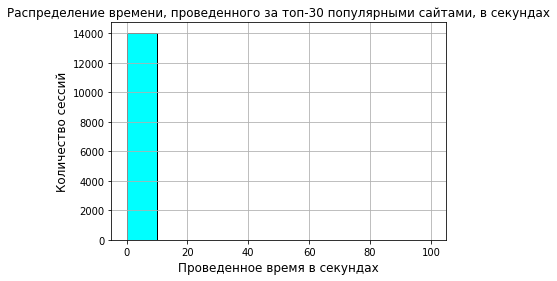

In [42]:
new2_features_10users['popular_sites_time'].hist(range=(0, 100), color='aqua', 
                                                edgecolor='black')
plt.xlabel(u'Проведенное время в секундах', fontsize='large')
plt.ylabel(u'Количество сессий', fontsize='large')
plt.title(u'Распределение времени, проведенного за топ-30 популярными сайтами, в секундах')
plt.show()

Гистограммы распределения времени, проведенного за топ-30 популярными сайтами, в секундах:


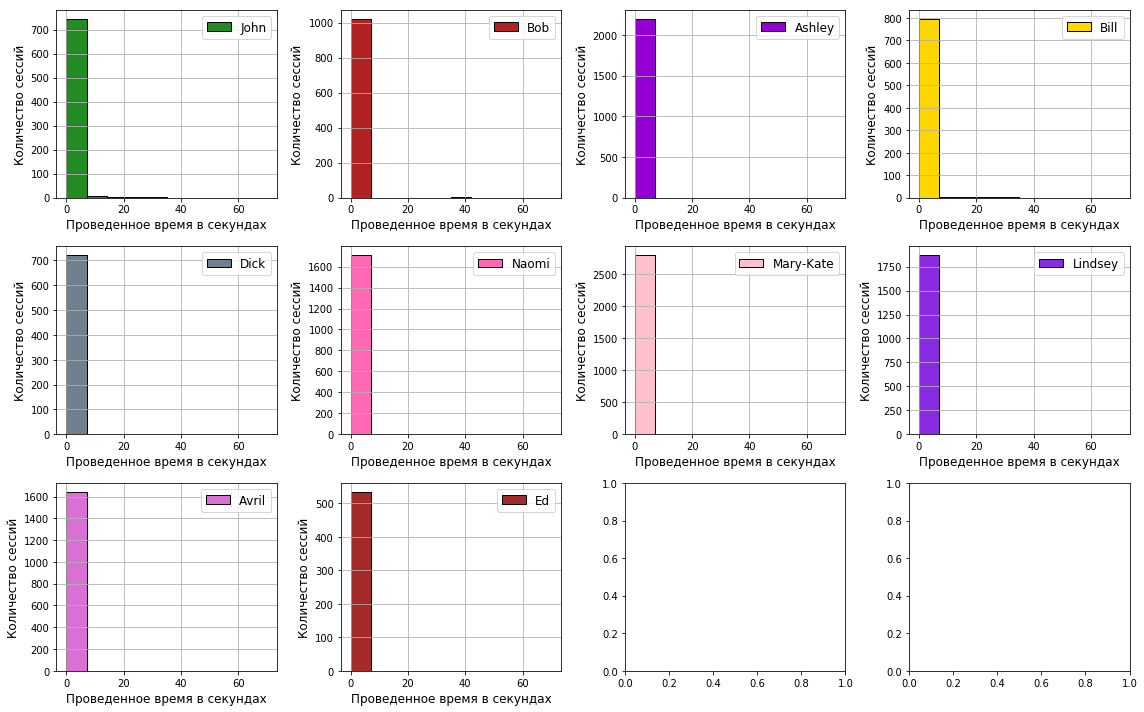

In [44]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
print(u'Гистограммы распределения времени, проведенного за топ-30 популярными сайтами, в секундах:')

for idx, (user, sub_df) in  enumerate(new2_features_10users.groupby('target')): 
    sub_df['popular_sites_time'].hist(range=(0, 70), color=color_dic[id_name_dict[user]], 
                                      ax=axes[idx//4, idx%4], edgecolor='black')
    axes[idx//4, idx%4].set_xlabel(u'Проведенное время в секундах', fontsize='large')
    axes[idx//4, idx%4].set_ylabel(u'Количество сессий', fontsize='large')
    axes[idx//4, idx%4].legend([id_name_dict[user]], fontsize='large')
plt.tight_layout()

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [45]:
selected_features_10users = np.hstack((new_features_10users, 
                                      new2_features_10users[['popular_sites', 
                                                             'popular_sites_time']]))
selected_features_150users = np.hstack((new_features_150users, 
                                       new2_features_150users[['popular_sites', 
                                                               'popular_sites_time']]))

In [46]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 